# Load libraries

In [1]:
import random
import numpy as np
import pandas as pd
from scipy.io import loadmat

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import umap

from scipy.stats import zscore

from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
# from sklearn.decomposition import PCA

import helpers.mc as mc
import drcme.ephys_morph_clustering as emc

# from sklearn.metrics import adjusted_rand_score, pair_confusion_matrix
from sklearn.metrics.cluster import contingency_matrix

In [2]:
# Set random seed
def set_seed(seed=None):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    print(f'Random seed {seed} has been set.')

seed=0
set_seed(seed=seed)

Random seed 0 has been set.


# Load S1 data

In [3]:
root_path = 'Y:/Data_Felipe/lookup_table/data/'

# Load raw features
M_raw, M_invalid_cells = mc.load_features(root_path + 'features/morph_features.mat')
E_raw, E_invalid_cells = mc.load_features(root_path + 'features/ephys_features.mat')

valid_cells = (~M_invalid_cells) * (~E_invalid_cells)

s1_morph = M_raw.loc[valid_cells,:]
s1_morph = s1_morph.iloc[:,:3].reset_index()
s1_morph.columns = ['idx', 'Soma depth', 'Axon vertical extent', 'Dendrite vertical extent']
s1_morph = s1_morph.iloc[:,1:]

metrics = loadmat(root_path + 'features/ephys_all_dataset_metrics.mat')
avg_freq = 100 * np.squeeze(metrics['Avg_freq'])[valid_cells] / \
    np.squeeze(metrics['Cont_ratio'])[valid_cells]
freq_adapt = np.squeeze(metrics['Freq_adapt'])[valid_cells]

mol_id = pd.read_table(root_path + 'classes/Features_cluster_assignments.dat', \
                       skiprows=1, header=None)
mol_id = np.squeeze(mol_id.values)[valid_cells].astype(int)-1
mol_classes = ['Pvalb', 'Sst', 'Vip','Lamp5']
mol_id = np.array([mol_classes[i] for i in mol_id])

s1_ephys = pd.DataFrame(np.stack((avg_freq, freq_adapt, mol_id), axis=1), \
                        columns=['Spike-frequency', 'Spike-frequency adaptation', 'mol-type'])

s1_data = s1_morph.join(s1_ephys)

s1_labs = s1_data.loc[:,s1_data.columns.str.contains('-type')]

In [4]:
S1 = s1_data.iloc[:,:5].astype(float)
S1_zscore = zscore(S1)

In [5]:
soma_depth = s1_data['Soma depth'].values

s1_L1  = soma_depth < 0.150
s1_L23 = (0.150 <= soma_depth) & (soma_depth < 0.551)
s1_L4  = (0.551 <= soma_depth) & (soma_depth < 0.847)
s1_L5  = (0.847 <= soma_depth) & (soma_depth < 1.342)
s1_L6  = (1.342 <= soma_depth) & (soma_depth < 1.887)

s1_labs.loc[s1_L1,  'layer'] = 'L1'
s1_labs.loc[s1_L23, 'layer'] = 'L2/3'
s1_labs.loc[s1_L4,  'layer'] = 'L4'
s1_labs.loc[s1_L5,  'layer'] = 'L5'
s1_labs.loc[s1_L6,  'layer'] = 'L6'

C:\Users\yanez\AppData\Local\Temp\ipykernel_26384\49187970.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s1_labs.loc[s1_L1,  'layer'] = 'L1'


# Load V1 data

In [6]:
root_path = 'C:/Users/yanez/Desktop/rehack/data'

In [7]:
# Load raw features
v1_morph = pd.read_csv(root_path + '/mouse v1/processed/morph/v1_patchseq_morph_features.csv')
v1_morph.set_index('cell id', inplace=True)

used_features = v1_morph.columns.str.contains('normalized depth|axon height|dendrite height')
v1_morph = v1_morph.loc[:,used_features]
v1_morph.columns = ['Soma depth', 'Axon vertical extent', 'Dendrite vertical extent']

v1_specimen_id = loadmat(root_path + '/mouse v1/processed/ephys/voltage_traces.mat', variable_names='specimen_id')
v1_metrics = loadmat(root_path + '/mouse v1/processed/ephys/ephys_all_datasets.mat')
v1_avg_freq = 100 * np.squeeze(v1_metrics['Avg_freq']) / np.squeeze(v1_metrics['Cont_ratio'])
v1_freq_adapt = np.squeeze(v1_metrics['Freq_adapt'])

v1_met_type = loadmat(root_path + '/mouse v1/processed/ephys/voltage_traces.mat', variable_names='met_type')
v1_met_type = [x.strip(' ') for x in v1_met_type['met_type']]

v1_t_type = loadmat(root_path + '/mouse v1/processed/ephys/voltage_traces.mat', variable_names='t_type')
v1_t_type = [x.strip(' ') for x in v1_t_type['t_type']]

v1_mol_id = [x.split(' ')[0] for x in v1_t_type]

v1_ephys = pd.DataFrame(np.stack((v1_avg_freq, v1_freq_adapt, v1_met_type, v1_t_type, v1_mol_id), axis=1), \
                        columns=['Spike-frequency', 'Spike-frequency adaptation', 'met-type', 't-type', 'mol-type'], \
                        index=v1_specimen_id['specimen_id'][0])
adapt_valid_cells = v1_ephys['Spike-frequency adaptation'].values!='nan'
v1_ephys = v1_ephys.loc[adapt_valid_cells,:]

v1_data = v1_morph.join(v1_ephys, how='inner')

# ttype_valid_cells = (v1_data['mol-type'].values!='Serpinf1') & (v1_data['mol-type'].values!='Sncg')
ttype_valid_cells = (v1_data['mol-type'].values!='Serpinf1')
v1_data = v1_data.loc[ttype_valid_cells,:]

v1_labs = v1_data.loc[:,v1_data.columns.str.contains('-type')]


# # use depth from the metadata file
# v1_depth = pd.read_csv(root_path + '/mouse v1/20200711_patchseq_metadata_mouse.csv', \
#     usecols=['cell_specimen_id', 'cell_soma_normalized_depth'])

# v1_data['Soma depth'] = v1_depth.set_index('cell_specimen_id').loc[v1_labs.index,:]

In [8]:
V1 = v1_data.iloc[:,:5].astype(float)
V1['Axon vertical extent'] /= 1000
V1['Dendrite vertical extent'] /= 1000
V1_zscore = zscore(V1)

In [9]:
soma_depth = v1_data['Soma depth'].values

v1_L1  = soma_depth < 0.12477018691931971
v1_L23 = (0.12477018691931971 <= soma_depth) & (soma_depth < 0.36144679936288815)
v1_L4  = (0.36144679936288815 <= soma_depth) & (soma_depth < 0.49168601217438207)
v1_L5  = (0.49168601217438207 <= soma_depth) & (soma_depth < 0.74534854940761)
v1_L6  = (0.74534854940761 <= soma_depth) & (soma_depth < 1.0)

v1_labs.loc[v1_L1,  'layer'] = 'L1'
v1_labs.loc[v1_L23, 'layer'] = 'L2/3'
v1_labs.loc[v1_L4,  'layer'] = 'L4'
v1_labs.loc[v1_L5,  'layer'] = 'L5'
v1_labs.loc[v1_L6,  'layer'] = 'L6'

C:\Users\yanez\AppData\Local\Temp\ipykernel_26384\1180431148.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v1_labs.loc[v1_L1,  'layer'] = 'L1'


# Load M1 data

In [10]:
# Load raw features
m1_morph = pd.read_csv(root_path + '/mouse m1/processed/morph/m1_patchseq_morph_features.csv')
m1_morph.set_index('cell id', inplace=True)

used_features = m1_morph.columns.str.contains('normalized depth|axon height|dendrite height')
m1_morph = m1_morph.loc[:,used_features]
m1_morph.columns = ['Soma depth', 'Axon vertical extent', 'Dendrite vertical extent']

m1_specimen_id = loadmat(root_path + '/mouse m1/processed/ephys/voltage_traces.mat', variable_names='specimen_id')
m1_metrics = loadmat(root_path + '/mouse m1/processed/ephys/ephys_all_datasets.mat')
m1_avg_freq = 100 * np.squeeze(m1_metrics['Avg_freq']) / np.squeeze(m1_metrics['Cont_ratio'])
m1_freq_adapt = np.squeeze(m1_metrics['Freq_adapt'])

m1_t_type = loadmat(root_path + '/mouse m1/processed/ephys/voltage_traces.mat', variable_names='t_type')
m1_t_type = [x.strip(' ') for x in m1_t_type['t_type']]

m1_mol_id = [x.split(' ')[0] for x in m1_t_type]

m1_ephys = pd.DataFrame(np.stack((m1_avg_freq, m1_freq_adapt, m1_t_type, m1_mol_id), axis=1), \
                       columns=['Spike-frequency', 'Spike-frequency adaptation', 't-type', 'mol-type'], \
                       index=m1_specimen_id['specimen_id'])
m1_ephys = m1_ephys.sort_index()
adapt_valid_cells = m1_ephys['Spike-frequency adaptation'].values!='nan'
m1_ephys = m1_ephys.loc[adapt_valid_cells,:]
m1_morph = m1_morph.loc[adapt_valid_cells,:]

m1_ephys.reset_index(drop=True, inplace=True)
m1_morph.reset_index(drop=True, inplace=True)

m1_data = pd.concat([m1_morph, m1_ephys], axis=1) 
ttype_valid_cells = (m1_data['t-type'].values!='nan') #& (m1_data['mol-type'].values!='Sncg')
m1_data = m1_data.loc[ttype_valid_cells,:]

m1_labs = m1_data.loc[:,m1_data.columns.str.contains('-type')]

In [11]:
M1 = m1_data.iloc[:,:5].astype(float)
M1['Axon vertical extent'] /= 1000
M1['Dendrite vertical extent'] /= 1000
M1_zscore = zscore(M1)

In [12]:
soma_depth = m1_data['Soma depth'].values

m1_L1  = soma_depth < 0.07
m1_L23 = (0.07 <= soma_depth) & (soma_depth < 0.29)
m1_L5  = (0.29 <= soma_depth) & (soma_depth < 0.73)
m1_L6  = (0.73 <= soma_depth) & (soma_depth < 1.0)

m1_labs.loc[m1_L1,  'layer'] = 'L1'
m1_labs.loc[m1_L23, 'layer'] = 'L2/3'
m1_labs.loc[m1_L5,  'layer'] = 'L5'
m1_labs.loc[m1_L6,  'layer'] = 'L6'

C:\Users\yanez\AppData\Local\Temp\ipykernel_26384\2253447108.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m1_labs.loc[m1_L1,  'layer'] = 'L1'


# Visualize features per layer

In [13]:
# Create custom blue-white-red colormap
rr = np.array([239, 138,  98, 255]) / 255
ww = np.array([254, 254, 254, 255]) / 255
bb = np.array([103, 169, 207, 255]) / 255

newcolors = np.vstack((np.linspace(bb, ww, 128), np.linspace(ww, rr, 128)))
cmap = ListedColormap(newcolors, name='mycolormap')

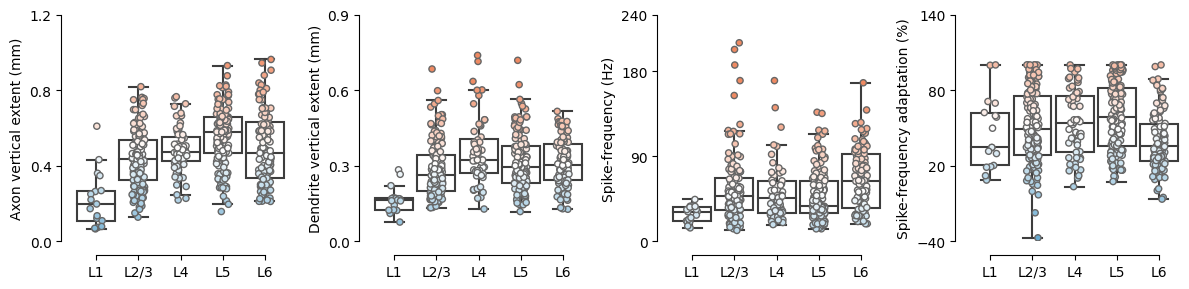

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,3), frameon=True)

s, s_large = 15, 45
bg_light = np.array([[0.8, 0.8, 0.8]])
bg_dark  = np.array([[0.4, 0.4, 0.4]])

all_ticks = [[0, 0.4, 0.8, 1.2], \
             [0, 0.3, 0.6, 0.9], \
             [0, 90, 180, 240], \
             [-40, 20, 80, 140]]

V1_now = V1.copy().iloc[:,1:]

units = [' (mm)', ' (mm)', ' (Hz)', ' (%)']
V1_now.columns = [V1_now.columns[i]+units[i] for i in range(len(units))]

V1_now['layer'] = v1_labs['layer'].values 

V1_now = V1_now.sort_values(by=['layer'])

V1_zscore_now = V1_zscore.copy().iloc[:,1:]

V1_zscore_now.columns = [V1_zscore_now.columns[i]+units[i] for i in range(len(units))]

V1_zscore_now['layer'] = v1_labs['layer'].values 

V1_zscore_now = V1_zscore_now.sort_values(by=['layer'])



sz = 20
bg_dark  = np.array([[0.4, 0.4, 0.4]])
kwargs = {'edgecolor':bg_dark, 'linewidth':1.0}

for (i, tk, ax) in zip(V1_now.columns[:-1], all_ticks, axs):

    ax.set_ylim([tk[0], tk[-1]])
    ax.set_yticks(tk) 
    width = 0.9
    sns.boxplot(data=V1_now, x='layer', y=i, showfliers=False, 
                boxprops={'facecolor':'None'}, width=width, ax=ax)
    
    s = sns.scatterplot(data=V1_now, x='layer', y=i, s=sz, markers='o',
                        cmap=cmap, c=V1_zscore_now[i], legend=False, 
                        vmin=-3, vmax=3, ax=ax, **kwargs)
    pts = s.collections[0]
    pts_rand = np.c_[np.random.uniform(-0.15, .15, len(V1_now)), np.zeros(len(V1_now))]
    pts.set_offsets(pts.get_offsets() + pts_rand)
    pts.set_zorder(20)
        
    ax.legend([],[],frameon=False)
    sns.despine(offset=10, trim=True)  
    ax.set_xlabel('')

fig.tight_layout()
plt.show()

fig.savefig('results/V1_features_per_layer.png', \
    dpi=1200, transparent=True, bbox_inches='tight')

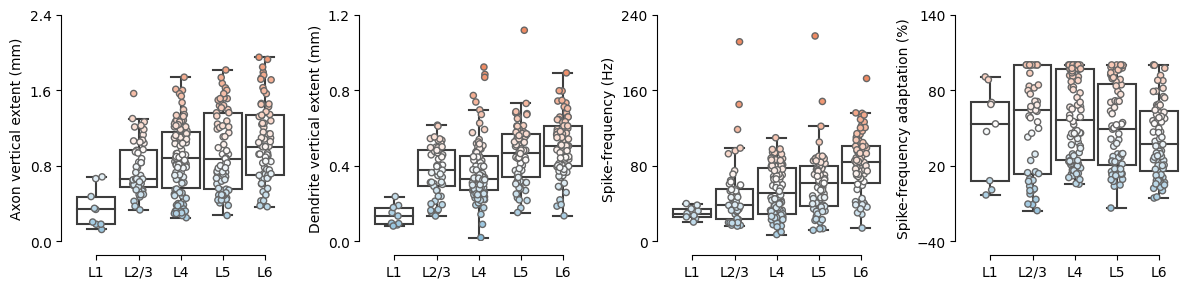

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,3), frameon=True)

s, s_large = 15, 45
bg_light = np.array([[0.8, 0.8, 0.8]])
bg_dark  = np.array([[0.4, 0.4, 0.4]])

all_ticks = [[0, 0.8, 1.6, 2.4], \
             [0, 0.4, 0.8, 1.2], \
             [0, 80, 160, 240], \
             [-40, 20, 80, 140]]

S1_now = S1.copy().iloc[:,1:]

units = [' (mm)', ' (mm)', ' (Hz)', ' (%)']
S1_now.columns = [S1_now.columns[i]+units[i] for i in range(len(units))]

S1_now['layer'] = s1_labs['layer'].values 

S1_now = S1_now.sort_values(by=['layer'])

S1_zscore_now = S1_zscore.copy().iloc[:,1:]

S1_zscore_now.columns = [S1_zscore_now.columns[i]+units[i] for i in range(len(units))]

S1_zscore_now['layer'] = s1_labs['layer'].values 

S1_zscore_now = S1_zscore_now.sort_values(by=['layer'])



sz = 20
bg_dark  = np.array([[0.4, 0.4, 0.4]])
kwargs = {'edgecolor':bg_dark, 'linewidth':1.0}

for (i, tk, ax) in zip(S1_now.columns[:-1], all_ticks, axs):

    ax.set_ylim([tk[0], tk[-1]])
    ax.set_yticks(tk) 
    width = 0.9
    sns.boxplot(data=S1_now, x='layer', y=i, showfliers=False, 
                boxprops={'facecolor':'None'}, width=width, ax=ax)
    
    s = sns.scatterplot(data=S1_now, x='layer', y=i, s=sz, markers='o',
                        cmap=cmap, c=S1_zscore_now[i], legend=False, 
                        vmin=-3, vmax=3, ax=ax, **kwargs)
    pts = s.collections[0]
    pts_rand = np.c_[np.random.uniform(-0.15, .15, len(S1_now)), np.zeros(len(S1_now))]
    pts.set_offsets(pts.get_offsets() + pts_rand)
    pts.set_zorder(20)
        
    ax.legend([],[],frameon=False)
    sns.despine(offset=10, trim=True)  
    ax.set_xlabel('')

fig.tight_layout()
plt.show()

fig.savefig('results/S1_features_per_layer.png', \
    dpi=1200, transparent=True, bbox_inches='tight')

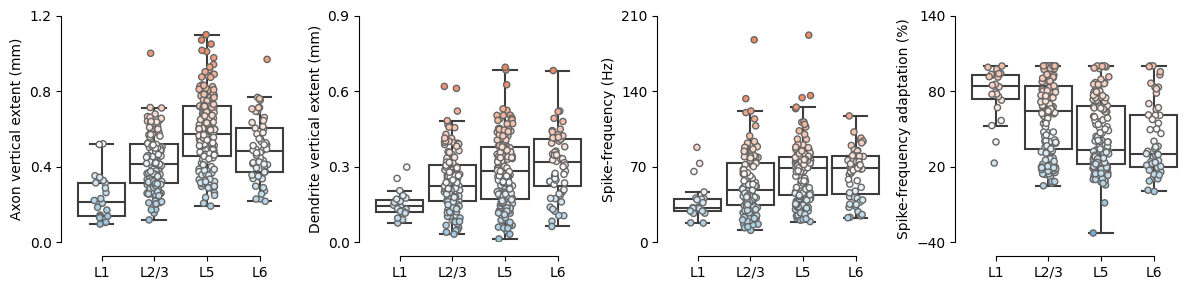

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,3), frameon=True)

s, s_large = 15, 45
bg_light = np.array([[0.8, 0.8, 0.8]])
bg_dark  = np.array([[0.4, 0.4, 0.4]])

all_ticks = [[0, 0.4, 0.8, 1.2], \
             [0, 0.3, 0.6, 0.9], \
             [0, 70, 140, 210], \
             [-40, 20, 80, 140]]

M1_now = M1.copy().iloc[:,1:]

units = [' (mm)', ' (mm)', ' (Hz)', ' (%)']
M1_now.columns = [M1_now.columns[i]+units[i] for i in range(len(units))]

M1_now['layer'] = m1_labs['layer'].values 

M1_now = M1_now.sort_values(by=['layer'])

M1_zscore_now = M1_zscore.copy().iloc[:,1:]

M1_zscore_now.columns = [M1_zscore_now.columns[i]+units[i] for i in range(len(units))]

M1_zscore_now['layer'] = m1_labs['layer'].values 

M1_zscore_now = M1_zscore_now.sort_values(by=['layer'])



sz = 20
bg_dark  = np.array([[0.4, 0.4, 0.4]])
kwargs = {'edgecolor':bg_dark, 'linewidth':1.0}

for (i, tk, ax) in zip(M1_now.columns[:-1], all_ticks, axs):

    ax.set_ylim([tk[0], tk[-1]])
    ax.set_yticks(tk) 
    width = 0.9
    sns.boxplot(data=M1_now, x='layer', y=i, showfliers=False, 
                boxprops={'facecolor':'None'}, width=width, ax=ax)
    
    s = sns.scatterplot(data=M1_now, x='layer', y=i, s=sz, markers='o',
                        cmap=cmap, c=M1_zscore_now[i], legend=False, 
                        vmin=-3, vmax=3, ax=ax, **kwargs)
    pts = s.collections[0]
    pts_rand = np.c_[np.random.uniform(-0.15, .15, len(M1_now)), np.zeros(len(M1_now))]
    pts.set_offsets(pts.get_offsets() + pts_rand)
    pts.set_zorder(20)

        
    ax.legend([],[],frameon=False)
    sns.despine(offset=10, trim=True)  
    ax.set_xlabel('')

fig.tight_layout()
plt.show()

fig.savefig('results/M1_features_per_layer.png', \
    dpi=1200, transparent=True, bbox_inches='tight')

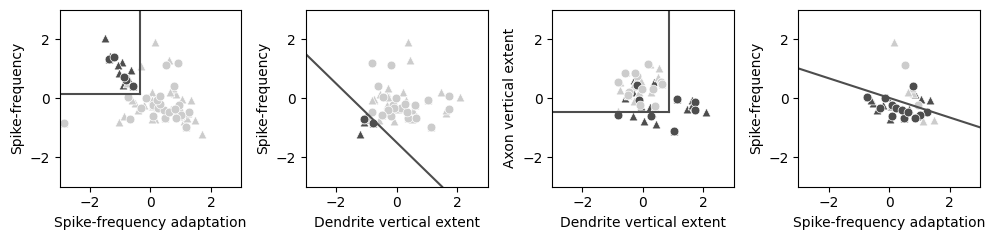

In [17]:
me_v1 = V1_zscore.groupby([v1_labs['met-type']]).mean(numeric_only=True) 
mid = np.array([x.split('-')[0] for x in me_v1.index])

me_v1_t = V1_zscore.groupby([v1_labs['t-type']]).mean(numeric_only=True) 
mid_t = np.array([x.split(' ')[0] for x in me_v1_t.index])



fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,2.5), frameon=True)


bg_light = np.array([[0.8, 0.8, 0.8]])
bg_dark  = np.array([[0.3, 0.3, 0.3]])

marker, sz = 'o', 40

##############################################################################
### R1: Pvalb
##############################################################################

df_t = me_v1_t
sns.scatterplot(data=df_t.iloc[mid_t=='Pvalb',:], 
                x='Spike-frequency adaptation', y='Spike-frequency', 
                c=bg_dark, legend=False, marker='^', s=sz, ax=ax[0])
sns.scatterplot(data=df_t.iloc[mid_t!='Pvalb',:], 
                x='Spike-frequency adaptation', y='Spike-frequency', 
                c=bg_light, legend=False, marker='^', s=sz, ax=ax[0])

df = me_v1
sns.scatterplot(data=df.iloc[mid=='Pvalb',:], 
                x='Spike-frequency adaptation', y='Spike-frequency', 
                c=bg_dark, legend=False, marker=marker, s=sz, ax=ax[0])
sns.scatterplot(data=df.iloc[mid!='Pvalb',:], 
                x='Spike-frequency adaptation', y='Spike-frequency', 
                c=bg_light, legend=False, marker=marker, s=sz, ax=ax[0])


r1_v1_wx, r1_v1_wy = -0.35, 0.15
ax[0].plot([      -3, r1_v1_wx], [r1_v1_wy, r1_v1_wy], color=bg_dark)
ax[0].plot([r1_v1_wx, r1_v1_wx], [r1_v1_wy,        3], color=bg_dark)
# ax[0].axline((-3,-2.2), slope=1, color=bg_dark)


##############################################################################
### R2: Lamp5
##############################################################################

idx_t = ~( (df_t['Spike-frequency adaptation'].values < r1_v1_wx) * \
    (df_t['Spike-frequency'].values > r1_v1_wy) )
df_t, mid_t = df_t.iloc[idx_t,:], mid_t[idx_t]
sns.scatterplot(data=df_t.iloc[mid_t=='Lamp5',:], 
                x='Dendrite vertical extent', y='Spike-frequency', 
                c=bg_dark, legend=False, marker='^', s=sz, ax=ax[1])
sns.scatterplot(data=df_t.iloc[mid_t!='Lamp5',:], 
                x='Dendrite vertical extent', y='Spike-frequency', 
                c=bg_light, legend=False, marker='^', s=sz, ax=ax[1])

idx = ~( (df['Spike-frequency adaptation'].values < r1_v1_wx) * \
    (df['Spike-frequency'].values > r1_v1_wy) )
df, mid = df.iloc[idx,:], mid[idx]
sns.scatterplot(data=df.iloc[mid=='Lamp5',:], 
                x='Dendrite vertical extent', y='Spike-frequency', 
                c=bg_dark, legend=False, marker=marker, s=sz, ax=ax[1])
sns.scatterplot(data=df.iloc[mid!='Lamp5',:], 
                x='Dendrite vertical extent', y='Spike-frequency', 
                c=bg_light, legend=False, marker=marker, s=sz, ax=ax[1])

r2_v1_ws, r2_v1_wb = -1, -3/2
ax[1].axline((r2_v1_wb, 0), slope=r2_v1_ws, color=bg_dark)


##############################################################################
### R3: Vip
##############################################################################

idx_t = ~( df_t['Spike-frequency'].values < \
    (r2_v1_ws * df_t['Dendrite vertical extent'].values + r2_v1_wb) )
df_t, mid_t = df_t.iloc[idx_t,:], mid_t[idx_t]
sns.scatterplot(data=df_t.iloc[mid_t!='Sst',:], 
                x='Dendrite vertical extent', y='Axon vertical extent', 
                c=bg_dark, legend=False, marker='^', s=sz, ax=ax[2])
sns.scatterplot(data=df_t.iloc[mid_t=='Sst',:], 
                x='Dendrite vertical extent', y='Axon vertical extent', 
                c=bg_light, legend=False, marker='^', s=sz, ax=ax[2])

idx = ~( df['Spike-frequency'].values < \
    (r2_v1_ws * df['Dendrite vertical extent'].values + r2_v1_wb) )
df, mid = df.iloc[idx,:], mid[idx]
sns.scatterplot(data=df.iloc[mid!='Sst',:], 
                x='Dendrite vertical extent', y='Axon vertical extent', 
                c=bg_dark, legend=False, marker=marker, s=sz, ax=ax[2])
sns.scatterplot(data=df.iloc[mid=='Sst',:], 
                x='Dendrite vertical extent', y='Axon vertical extent', 
                c=bg_light, legend=False, marker=marker, s=sz, ax=ax[2])


r3_v1_wx, r3_v1_wy = 0.85, -0.45
ax[2].plot([      -3, r3_v1_wx], [r3_v1_wy, r3_v1_wy], color=bg_dark)
ax[2].plot([r3_v1_wx, r3_v1_wx], [r3_v1_wy,        3], color=bg_dark)
# w1, w2 = 0.3, -0.5
# ax[2].plot([-3, w1], [w2, w2], color=bg_dark)
# ax[2].plot([w1, 3], [w2, 2.2], color=bg_dark)


##############################################################################
### R4: Sst
##############################################################################

idx_t = ~( (df_t['Dendrite vertical extent'].values > r3_v1_wx) + \
    (df_t['Axon vertical extent'].values < r3_v1_wy) )
df_t = df_t.iloc[idx_t,:]
mid_t = mid_t[idx_t]
sns.scatterplot(data=df_t.iloc[mid_t=='Sst',:], 
                x='Spike-frequency adaptation', y='Spike-frequency', 
                c=bg_dark, legend=False, marker='^', s=sz, ax=ax[3])
sns.scatterplot(data=df_t.iloc[mid_t!='Sst',:], 
                x='Spike-frequency adaptation', y='Spike-frequency', 
                c=bg_light, legend=False, marker='^', s=sz, ax=ax[3])

idx = ~( (df['Dendrite vertical extent'].values > r3_v1_wx) + \
    (df['Axon vertical extent'].values < r3_v1_wy) )
df = df.iloc[idx,:]
mid = mid[idx]
sns.scatterplot(data=df.iloc[mid=='Sst',:], 
                x='Spike-frequency adaptation', y='Spike-frequency', 
                c=bg_dark, legend=False, marker=marker, s=sz, ax=ax[3])
sns.scatterplot(data=df.iloc[mid!='Sst',:], 
                x='Spike-frequency adaptation', y='Spike-frequency', 
                c=bg_light, legend=False, marker=marker, s=sz, ax=ax[3])


r4_v1_ws, r4_v1_wb = -1/3, 0.05
ax[3].axline((r4_v1_wb, 0), slope=r4_v1_ws, color=bg_dark)
# w1, w2 = 0.8, -0.35
# ax[3].plot([w1, 3], [w2, w2], color=bg_dark)
# ax[3].plot([w1, w1], [w2, 3], color=bg_dark)
# ax[3].axline((-2.35,3), slope=-1, color='g')


##############################################################################
for i in range(4):
    ax[i].set_xlim([-3, 3])
    ax[i].set_ylim([-3, 3])
    ax[i].set_xticks([-2, 0, 2])
    ax[i].set_yticks([-2, 0, 2])

fig.tight_layout()
plt.show()

fig.savefig('results/V1_principles.png', \
    dpi=1200, transparent=True, bbox_inches='tight')

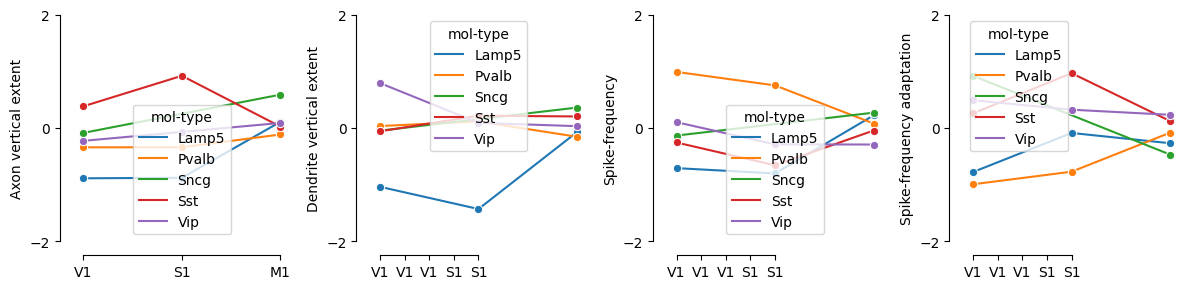

In [197]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,3), frameon=True)

s, s_large = 15, 45
bg_light = np.array([[0.8, 0.8, 0.8]])
bg_dark  = np.array([[0.4, 0.4, 0.4]])

V1_moltype = V1_zscore.groupby([v1_labs['mol-type']]).mean(numeric_only=True) 
V1_moltype['mol-type'] = V1_moltype.index
V1_moltype['area'] = 'V1'

S1_moltype = S1_zscore.groupby([s1_labs['mol-type']]).mean(numeric_only=True) 
S1_moltype['mol-type'] = S1_moltype.index
S1_moltype['area'] = 'S1'

M1_moltype = M1_zscore.groupby([m1_labs['mol-type']]).mean(numeric_only=True) 
M1_moltype['mol-type'] = M1_moltype.index
M1_moltype['area'] = 'M1'

dt = pd.concat([V1_moltype, S1_moltype, M1_moltype], axis=0)


sz = 20
bg_dark  = np.array([[0.4, 0.4, 0.4]])
kwargs = {'edgecolor':bg_dark, 'linewidth':1.0}

for (i, ax) in zip(dt.columns[1:5], axs):

    ax.set_ylim([-2, 2])
    ax.set_yticks([-2,0,2])
    # ax.set_xticklabels(['V1', 'S1', 'M1']) 
    sns.lineplot(data=dt, x='area', y=i, hue='mol-type', marker='o', ax=ax)

    # ax.legend([],[],frameon=False)
    sns.despine(offset=10, trim=True)  
    ax.set_xlabel('')

fig.tight_layout()
plt.show()

# fig.savefig('results/M1_features_per_layer.tif', \
#     dpi=600, transparent=True, bbox_inches='tight')

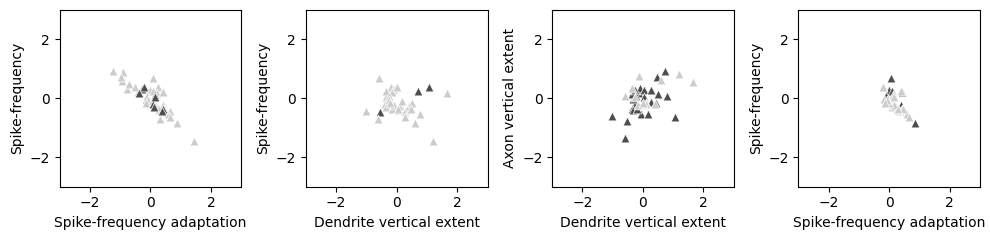

In [18]:
me_m1_t = M1_zscore.groupby([m1_labs['t-type']]).mean(numeric_only=True) 
mid_t = np.array([x.split(' ')[0] for x in me_m1_t.index])





fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,2.5), frameon=True)


bg_light = np.array([[0.8, 0.8, 0.8]])
bg_dark  = np.array([[0.3, 0.3, 0.3]])

marker, sz = 'o', 40

##############################################################################
### R1: Pvalb
##############################################################################

df_t = me_m1_t
sns.scatterplot(data=df_t.iloc[mid_t!='Pvalb',:], 
                x='Spike-frequency adaptation', y='Spike-frequency', 
                c=bg_light, legend=False, marker='^', s=sz, ax=ax[0])
sns.scatterplot(data=df_t.iloc[mid_t=='Pvalb',:], 
                x='Spike-frequency adaptation', y='Spike-frequency', 
                c=bg_dark, legend=False, marker='^', s=sz, ax=ax[0])


# r1_v1_wx, r1_v1_wy = -0.35, 0.15
# ax[0].plot([      -3, r1_v1_wx], [r1_v1_wy, r1_v1_wy], color=bg_dark)
# ax[0].plot([r1_v1_wx, r1_v1_wx], [r1_v1_wy,        3], color=bg_dark)
# ax[0].axline((-3,-2.2), slope=1, color=bg_dark)


##############################################################################
### R2: Lamp5
##############################################################################

idx_t = ~( (df_t['Spike-frequency adaptation'].values < r1_v1_wx) * \
    (df_t['Spike-frequency'].values > r1_v1_wy) )
df_t, mid_t = df_t.iloc[idx_t,:], mid_t[idx_t]
sns.scatterplot(data=df_t.iloc[mid_t=='Lamp5',:], 
                x='Dendrite vertical extent', y='Spike-frequency', 
                c=bg_dark, legend=False, marker='^', s=sz, ax=ax[1])
sns.scatterplot(data=df_t.iloc[mid_t!='Lamp5',:], 
                x='Dendrite vertical extent', y='Spike-frequency', 
                c=bg_light, legend=False, marker='^', s=sz, ax=ax[1])

# r2_v1_ws, r2_v1_wb = -1, -3/2
# ax[1].axline((r2_v1_wb, 0), slope=r2_v1_ws, color=bg_dark)


##############################################################################
### R3: Vip
##############################################################################

idx_t = ~( df_t['Spike-frequency'].values < \
    (r2_v1_ws * df_t['Dendrite vertical extent'].values + r2_v1_wb) )
df_t, mid_t = df_t.iloc[idx_t,:], mid_t[idx_t]
sns.scatterplot(data=df_t.iloc[mid_t!='Sst',:], 
                x='Dendrite vertical extent', y='Axon vertical extent', 
                c=bg_dark, legend=False, marker='^', s=sz, ax=ax[2])
sns.scatterplot(data=df_t.iloc[mid_t=='Sst',:], 
                x='Dendrite vertical extent', y='Axon vertical extent', 
                c=bg_light, legend=False, marker='^', s=sz, ax=ax[2])


# r3_v1_wx, r3_v1_wy = 0.85, -0.45
# ax[2].plot([      -3, r3_v1_wx], [r3_v1_wy, r3_v1_wy], color=bg_dark)
# ax[2].plot([r3_v1_wx, r3_v1_wx], [r3_v1_wy,        3], color=bg_dark)
# w1, w2 = 0.3, -0.5
# ax[2].plot([-3, w1], [w2, w2], color=bg_dark)
# ax[2].plot([w1, 3], [w2, 2.2], color=bg_dark)


##############################################################################
### R4: Sst
##############################################################################

idx_t = ~( (df_t['Dendrite vertical extent'].values > r3_v1_wx) + \
    (df_t['Axon vertical extent'].values < r3_v1_wy) )
df_t = df_t.iloc[idx_t,:]
mid_t = mid_t[idx_t]
sns.scatterplot(data=df_t.iloc[mid_t=='Sst',:], 
                x='Spike-frequency adaptation', y='Spike-frequency', 
                c=bg_dark, legend=False, marker='^', s=sz, ax=ax[3])
sns.scatterplot(data=df_t.iloc[mid_t!='Sst',:], 
                x='Spike-frequency adaptation', y='Spike-frequency', 
                c=bg_light, legend=False, marker='^', s=sz, ax=ax[3])


# r4_v1_ws, r4_v1_wb = -1/3, 0.05
# ax[3].axline((r4_v1_wb, 0), slope=r4_v1_ws, color=bg_dark)
# w1, w2 = 0.8, -0.35
# ax[3].plot([w1, 3], [w2, w2], color=bg_dark)
# ax[3].plot([w1, w1], [w2, 3], color=bg_dark)
# ax[3].axline((-2.35,3), slope=-1, color='g')


##############################################################################
for i in range(4):
    ax[i].set_xlim([-3, 3])
    ax[i].set_ylim([-3, 3])
    ax[i].set_xticks([-2, 0, 2])
    ax[i].set_yticks([-2, 0, 2])

fig.tight_layout()
plt.show()

fig.savefig('results/M1_principles.png', \
    dpi=1200, transparent=True, bbox_inches='tight')

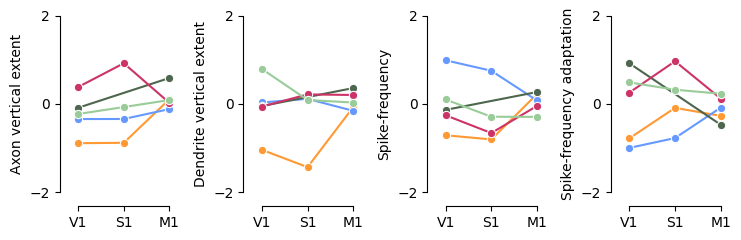

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(7.5,2.5), frameon=True)

# https://davidmathlogic.com/colorblind/#%236699FF-%23FF9933-%2399CC99-%23CC3366
pv_axon  = np.array([[102,153,255]])/255    #6699FF
nvp_axon = np.array([[255,153,51]])/255     #FF9933
vip_axon = np.array([[153,204,153]])/255    #99CC99
sst_axon = np.array([[204,51,102]])/255     #CC3366

palette = {'Lamp5': nvp_axon, 'Pvalb': pv_axon, 
           'Sncg': vip_axon/2, 'Sst': sst_axon, 'Vip': vip_axon}

s, s_large = 15, 45
bg_light = np.array([[0.8, 0.8, 0.8]])
bg_dark  = np.array([[0.4, 0.4, 0.4]])

V1_moltype = V1_zscore.groupby([v1_labs['mol-type']]).mean(numeric_only=True) 
V1_moltype['mol-type'] = V1_moltype.index
V1_moltype['area'] = 'V1'

S1_moltype = S1_zscore.groupby([s1_labs['mol-type']]).mean(numeric_only=True) 
S1_moltype['mol-type'] = S1_moltype.index
S1_moltype['area'] = 'S1'

M1_moltype = M1_zscore.groupby([m1_labs['mol-type']]).mean(numeric_only=True) 
M1_moltype['mol-type'] = M1_moltype.index
M1_moltype['area'] = 'M1'

dt = pd.concat([V1_moltype, S1_moltype, M1_moltype], axis=0, ignore_index=True)


sz = 20
bg_dark  = np.array([[0.4, 0.4, 0.4]])
kwargs = {'edgecolor':bg_dark, 'linewidth':1.0}

for (i, ax) in zip(dt.columns[1:5], axs):

    ax.set_ylim([-2, 2])
    ax.set_yticks([-2,0,2])
    ax.set_xticks([0,1,2])
    # ax.set_xticklabels(['V1', 'S1', 'M1']) 
    sns.lineplot(data=dt, x='area', y=i, hue='mol-type', palette=palette, marker='o', ax=ax)

    ax.legend([],[],frameon=False)
    sns.despine(offset=10, trim=True)  
    ax.set_xlabel('')

fig.tight_layout()
plt.show()

fig.savefig('results/mol_types_per_area.png', \
    dpi=1200, transparent=True, bbox_inches='tight')